## Solve knapsack problem using genetic algorithm

In this project we are going to see how genetic algorithm works and how answers(chromosomes that shows the combination of picking products) are getting better by time and how much crossover and mutation are important in this process. 

we want to find a way to picking up products to satisfy given constraints(min value, max capacity, number of products)
we do this by following genetic algorithm steps(selection, crossover, mutation)
first generate a random initial population(answers) and then try to make them better such that have the max value and also satisfy all 3 constraints.(maximum fitness)

import required libraries

In [1]:
import random
from matplotlib import pyplot as plt
import csv

In [2]:
#products = [product("Nani",5,5), product("Doogh-e-Abali",15,10), product("MazMaz",10,10), product("Jooj",7,15), product("Hot-Dog",20,15)]

CAPACITY = float(input())
MIN_VALUE = float(input())
MIN = int(input())
MAX = int(input())

# CAPACITY = 10
# MIN_VALUE = 12
# MIN = 2
# MAX = 4

MUTATION_PROB = 0.09
CROSSOVER_PROB = 0.75

values = []
max_values = []

In [3]:
class product:
    def __init__(self, name, weight, value):
        self.name = name
        self.weight = weight
        self.value = value
        

In [4]:
products = []
with open("snacks.csv", 'r') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    for row in csvreader:
        products.append(product(row[0], float(row[1]), float(row[2])))

### Part 1: Basic Concepts
define gene as float that shows how much we pick from a product.
define chromosome as an array of genes (array of floats) that each index in array is for one of the products. length of this array is equal to number of products.(chromosome is like a combination of picking items)

### Part 3: Fitness Function
the fitness function determines how good is our chromosome and we show this by sum of all value that we gain by picking that combination of products and actually use the most capacity and also satisfy those 3 constraints. if all 3 didn't hold at the same time we return 0.
so we define fitness function as bellow:
### $$fitness = \frac{sumValue}{CAPACITY - sumWeight}$$


$$sumValue = \Sigma bits_i values_i$$
$$sumWeight = \Sigma bits_i weights_i$$

In [5]:
class chromosome:
    def __init__(self, bits):
        self.bits = bits
    def fitness(self):
        sum_value = 0
        sum_weight = 0
        count = 0;
        for i in range(len(products)):
            sum_value += products[i].value * self.bits[i]
            sum_weight += products[i].weight * self.bits[i]
            if self.bits[i] != 0:
                count += 1
        if(sum_weight <= CAPACITY and sum_value >= MIN_VALUE and count <= MAX and count >= MIN):
            return (sum_value  / (CAPACITY - sum_weight))
        return 0


### Part 2: Generate Initial Population 
`num` = size of population

first we assume that each chromosome is an array of zeros and after that we randomly change them.
as we know that the number of products should be in given range we pick a random number in this range(k) and fill k random cells from chromosome array by a random float. we repeat this until the population size to be equal num.
    
another way to create the first chromosome is to randomly create combination and after that check the number of products range using fitness function but it takes more time than this way.    


In [6]:
def generate_initial_population(num):
    population = set()
    while(len(population) < num):
        combination = [0 for _ in range(len(products))]

        k = random.randint(MIN, MAX + 1)
        p = [i for i in range(len(products))]
        indexes = random.choices(p, k = k)
        for ind in indexes:
            combination[ind] = random.uniform(0, 1)
        c = chromosome(combination)
        population.add((c, c.fitness()))
    return list(population)    

for selection , first we sort the population by `fitness()` and return first quarter as parents.

In [7]:
def selection(population):
    parents = []

    population.sort(key = lambda x: x[0].fitness(), reverse = True)

    parents = population[:len(population) // 4]
    return parents
    

### Part 4: Implementing Crossover and Mutation and Generating Next Population

#### Crossover
we get `parents` and we should generate `m - len(parents)` children and return them.

1.we pick two parents 

2.generate random number and if it wat less that `CROSSOVER_PROB` we do crossover.

3.randomly generate an index for one point crossover

4.create two children

and we repeat this until we have  `m - len(parents)` children.
ans return all new children that we create.

#### Mutation
after crossover we should do mutation on those outputs so we give `after_crossover` to this function and for each chromosome we if the probability was less that `MUTATION_PROB` we randomly choose one index and flip it(if it was 0 we change it to a random float and otherwise change it to 0)
and we return all chromosomes(both changes and unchanged)

#### Generate Next Population
first by calling `selection()` we select 1/4 of the best chromosome from the last population and pass them without changes to the next generation.
then we call `crossover()` by the best 1/2 of chromosomes and do crossover on them and as the population size should be the same we must generate m - len(parents) children cause we pass parents to next generation before. after that we call `mutation()`.
and add results after mutation to next generation too.

In [8]:
def crossover(parents, m):
    n = len(products)
    after_crossover = []
    ind = 0
    random.shuffle(parents)
    while len(after_crossover) < m - len(parents):
            i = ind % len(parents)
            if random.random() < CROSSOVER_PROB:
                index = random.randint(1, n - 2)

                child_1 = parents[i][0].bits[:index] + parents[i + 1][0].bits[index:]
                child_2 = parents[i + 1][0].bits[:index] + parents[i][0].bits[index:]
                c_1 = chromosome(child_1)
                c_2 = chromosome(child_2)
                
                # if c_1.fitness() != 0:
                #     after_crossover.append((c_1, c_1.fitness()))
                # if c_2.fitness() != 0:
                #     after_crossover.append((c_2, c_2.fitness()))     
                after_crossover += [(c_1, c_1.fitness()), (c_2, c_2.fitness())]
                i += 1
    return after_crossover

In [9]:
def mutation(after_crossover):
    after_mutation = []
    for i in range(len(after_crossover)):
        chromosome_size = len(after_crossover[0][0].bits)
        after_mutation.append(after_crossover[i])
        if random.random() < MUTATION_PROB:
            bit = random.randint(0, chromosome_size - 1)
            if after_mutation[i][0].bits[bit] == 0:
                after_mutation[i][0].bits[bit] = random.uniform(0, 1)
            else:
                after_mutation[i][0].bits[bit] = 0       
    return after_mutation

In [10]:
def generate_next_generation(population):
    next = []

    parents = selection(population)
    next += parents

    population.sort(key = lambda x: x[0].fitness(), reverse = True)
    after_crossover = crossover(population[:len(population)// 3], len(population))
    
    after_mutation = mutation(after_crossover) 
    
    # for chromosome in after_mutation:
    #     if chromosome[0].fitness() != 0:
    #         next.append(chromosome)
    next += after_mutation
    return next 

calculate average fitness of a population.

In [11]:
def avg_fitness(population):
    sum = 0
    for i in range(len(population)):
        sum += population[i][0].fitness()
    return sum  / len(population)  

### Part 5: Running the Genetic Algorithm 
generate first population and then repeat generating next population by calling `generate_next_generation()`
after all we sort and return the chromosome with the most fitness().

In [12]:
def knapsack():
    population = generate_initial_population(100)
    for i in range(100):
        #print(i)
        population = generate_next_generation(population)
        population = sorted(population, key=lambda x: x[0].fitness(), reverse=True)
        # for p in population:
        #     print(p[0].fitness())  
        max_values.append(population[0][0].fitness())
        values.append(avg_fitness(population))
         
    population = sorted(population, key=lambda x: x[0].fitness(), reverse=True)
    
    return population[0][0].bits


then we show the changes of Max Fitness over generations and Average Fitness over generations and we can see that the answer(Fitness) changes and become better over time and converge to a specific fitness.

Jooj : 5.7244373862480105
Chips : 1.6114560794165502
Popcorn : 1.8901190946432926
Pastil : 0.043288260589196104
Masghati : 0.63047319826462
Total Weight: 9.89977401916167
Total Value: 15.868539145212443


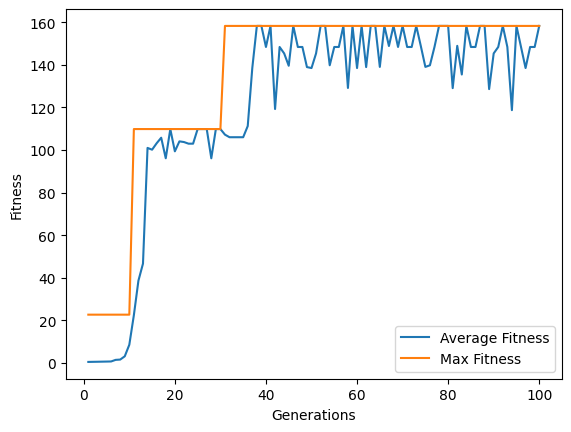

In [13]:
result = knapsack()
#print(result)
sum_value = 0
sum_weight = 0
weights = [0 for _ in range(len(products))]
for i in range(len(products)):
    sum_value += products[i].value * result[i]
    sum_weight += products[i].weight * result[i]
    weights[i] = products[i].weight * result[i]

#print("weights:", weights)
for i in range(len(products)):
    if(weights[i] != 0):
        print(products[i].name, ':', weights[i])
print("Total Weight:", sum_weight)
print("Total Value:", sum_value)

x = []
for i in range(1, 101):
    x.append(i)
plt.plot(x, values, label = "Average Fitness")
plt.plot(x, max_values, label = "Max Fitness")
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.legend()
plt.show()

#### Q1:
if the population size be too small , the algorithm may not find the best answer because there isn't enough chromosome to select in each generation.
if the population size be too large, the algorithm take a long time to find the best answer from each generation.

#### Q2:
it can prove the efficiency of algorithm because we have more chromosome to select but its not that much useful because we can delete those chromosomes that have lower fitness in each generation and keep the population size constant and use less memory. and also if population become bigger and bigger it takes more time to find the best answer.
#### Q3:
crossover create new chromosomes by combining two chromosomes but mutation change one gene of chromosomes.

mutation is for escape from local maximum, crossover is for creating children with better fitness and improve chromosomes.

crossover probability is much more than mutation probability.

if we just use crossover we cant escape from local maximums. and if we just use mutation we can't create better chromosomes and find the best answer.

#### Q4:
we can change parameters like mutation probability , crossover probability or population size.these parameters are too effective.

we can change selection approach, it can help crossover function to much create better children and change the max fitness.

#### Q5:
we can use uniform crossover instead of one point crossover to avoid bias.

we can use mutation to escape from local maximums.(as we did)

we can run the algorithm multiple times with different initial populations.

#### Q6:
algorithm stops after limited number of generations.(we can choose that limit according to our experience)

